# Mac and Linux setup

Make sure to have enabled the environment set up for running `dimelo` analysis. See the readme for details. If you are running your jupyter notebook some way other than by the `jupyter notebook` command in the command line from within your activated `conda` environment, you may need to use `ipykernel` to connect this notebook appropriately to the environment with `dimelo` and `modkit` installed.

# Colab setup

If you are running in Google Colab, run the cell below. **You may need to run twice if e.g. the default package versions in your Colab instance need to change.** You should see the `pip` message `Successfully installed dimelo-1.0.0` before continuing.

If you're not on Colab, you can run this cell if you like but it will error out.

In [2]:
# Lets Colab access your Google drive
from google.colab import drive
drive.mount('/content/drive')
# Install condacolab to let us get the modkit dependency
!pip install -q condacolab
import condacolab
condacolab.install()
# Install modkit
!conda install nanoporetech::modkit==0.2.4
# Clone the repo, change the active path to be inside the repo, and install the package
!rm -r dimelo
!git clone -b modkit_parsing_main https://github.com/streetslab/dimelo
import os
os.chdir('dimelo')
!pip install .

# Initialization

In [1]:
from pathlib import Path

In [2]:
# Base input and output directories
test_data_dir = Path('./test/data')
output_dir = Path('./test/output')

output_dir.mkdir(exist_ok=True)

# Input files
ctcf_bam_file = test_data_dir / 'ctcf_demo.sorted.bam'
ctcf_guppy_bam_file = test_data_dir / 'winnowmap_guppy_merge_subset.updated.bam'
ctcf_target_regions = test_data_dir / 'ctcf_demo_peak.bed'
ctcf_off_target_regions = test_data_dir / 'ctcf_demo_not_peak.bed'

In [4]:
!wget https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.0.fasta.gz -O ./test/output/chm13.draft_v1.0.fasta.gz
!gunzip ./test/output/chm13.draft_v1.0.fasta.gz

--2024-01-23 12:15:47--  https://s3-us-west-2.amazonaws.com/human-pangenomics/T2T/CHM13/assemblies/chm13.draft_v1.0.fasta.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.240.48, 52.92.227.24, 52.92.236.80, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.240.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 890102223 (849M) [binary/octet-stream]
Saving to: ‘./test/output/chm13.draft_v1.0.fasta.gz’

./test/output/chm13 100%[===================>] 848.87M  9.63MB/s    in 85s     

2024-01-23 12:17:14 (9.93 MB/s) - ‘./test/output/chm13.draft_v1.0.fasta.gz’ saved [890102223/890102223]



In [9]:
ref_genome_file = Path('./test/output/chm13.draft_v1.0.fasta')

# Parsing

In [5]:
from dimelo import parse_bam

modkit found with expected version 0.2.4


The following cell is expected to error out, thanks to input BAM format checking.

In [6]:
pileup_file = parse_bam.pileup(
    input_file=ctcf_bam_file,
    output_name='ctcf_demo_pileup',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_files=[ctcf_target_regions],
    basemods=['A,0','CG,0'],
    # thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

ValueError: Base modification tags are out of spec (Mm and Ml instead of MM and ML). 

Consider using "modkit update-tags test/data/ctcf_demo.sorted.bam new_file.bam" in the command line with your conda environment active and then trying with the new file. For megalodon basecalling/modcalling, you may also need to pass "--mode ambiguous.
Be sure to index the resulting .bam file."

To fix this, follow the suggestion from the error and run `modkit update-tags`...

In [5]:
!modkit update-tags \
test/data/ctcf_demo.sorted.bam \
test/output/ctcf_demo.updated.bam \
--mode ambiguous

> done, 1024 records processed, 0 failed, 0 skipped                             


In [7]:
ctcf_bam_file_updated = output_dir / 'ctcf_demo.updated.bam'

...and reindex the resulting file.

In [7]:
import pysam

pysam.index(str(ctcf_bam_file_updated))

''

Finally, the updated .bam file can be parsed, both for pileup and read extraction:

In [10]:
pileup_file = parse_bam.pileup(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_pileup_on_target',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_files=[ctcf_target_regions,ctcf_off_target_regions],
    basemods=['A,0','CG,0'],
    thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

Processing from ['ctcf_demo_peak.bed', 'ctcf_demo_not_peak.bed'] using even 1000bp windows in either direction from bed region centers.
Writing new bed file regions.processed.bed
No specified number of cores requested. 8 available on machine, allocating 4
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.


> parsed user-input threshold 0.74509805 for mod-code Y
> parsed user-input threshold 0.74509805 for mod-code A
> parsed user-input threshold 0.74509805 for mod-code Z
> parsed user-input threshold 0.74509805 for mod-code a
> parsed user-input threshold 0.74509805 for mod-code m
> parsing BED at test/output/ctcf_demo_pileup_on_target/regions.processed.bed
> processed 300 BED lines
> calculated chunk size: 6, interval size 100000, processing 600000 positions concurrently
> Using filter threshold 0.74509805 for mod code Y.
> Using filter threshold 0.74509805 for mod code A.
> Using filter threshold 0.74509805 for mod code Z.
> Using filter threshold 0.74509805 for mod code a.
> Using filter threshold 0.74509805 for mod code m.
> Done, processed 123046 rows. Processed ~1012 reads and skipped zero reads.


In [9]:
# guppy_pileup_file = parse_bam.pileup(
#     input_file=ctcf_guppy_bam_file,
#     output_name='ctcf_demo_pileup_off_target',
#     ref_genome=ref_genome_file,
#     output_directory=output_dir,
#     bed_files=[ctcf_target_regions,ctcf_off_target_regions],
#     basemods=['A,0','CG,0'],
#     thresh=190,
#     window_size=1000,
#     # cores=None,
#     # cleanup=False
# )

In [11]:
extract_file = parse_bam.extract(
    input_file=ctcf_bam_file_updated,
    output_name='ctcf_demo_extract',
    ref_genome=ref_genome_file,
    output_directory=output_dir,
    bed_files=[ctcf_target_regions,ctcf_off_target_regions],
    basemods=['A,0','CG,0'],
    thresh=190,
    window_size=1000,
    # cores=None,
    # cleanup=False
)

Processing from ['ctcf_demo_peak.bed', 'ctcf_demo_not_peak.bed'] using even 1000bp windows in either direction from bed region centers.
Writing new bed file regions.processed.bed
No specified number of cores requested. 8 available on machine, allocating 4
Modification threshold of 190 assumed to be for range 0-255. 190/255=0.7450980392156863 will be sent to modkit.
Extracting A,0 sites


> specifying include-only BED outputs only mapped sites
> parsing BED at test/output/ctcf_demo_extract/regions.processed.bed
> processed 300 BED lines
> found BAM index, processing reads in 100000 base pair chunks
> processed 963 reads, 1278404 rows, skipped ~0 reads, failed ~0 reads


Adding A,0 to test/output/ctcf_demo_extract/reads.combined_basemods.h5
963 reads found in test/output/ctcf_demo_extract/reads.A,0.txt
Extracting CG,0 sites


> specifying include-only BED outputs only mapped sites
> parsing BED at test/output/ctcf_demo_extract/regions.processed.bed
> processed 300 BED lines
> found BAM index, processing reads in 100000 base pair chunks
> processed 963 reads, 106327 rows, skipped ~0 reads, failed ~0 reads


Adding CG,0 to test/output/ctcf_demo_extract/reads.combined_basemods.h5
963 reads found in test/output/ctcf_demo_extract/reads.CG,0.txt
extending from 963 to 1926


# Plotting

## Plot Enrichment Profile

In [12]:
from dimelo import plot_enrichment_profile

Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed
Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed


<Axes: xlabel='pos', ylabel='fraction modified bases'>

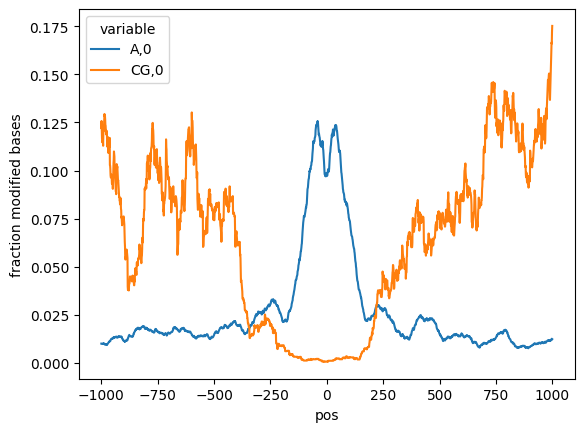

In [13]:
plot_enrichment_profile.by_modification(
    mod_file_name=pileup_file,
    bed_file_name=ctcf_target_regions,
    window_size=1000,
    mod_names=['A,0','CG,0'],
    smooth_window=50
)

Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed
Loading regions from ctcf_demo_not_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_not_peak.windowed1000-for-readout.bed


<Axes: xlabel='pos', ylabel='fraction modified bases'>

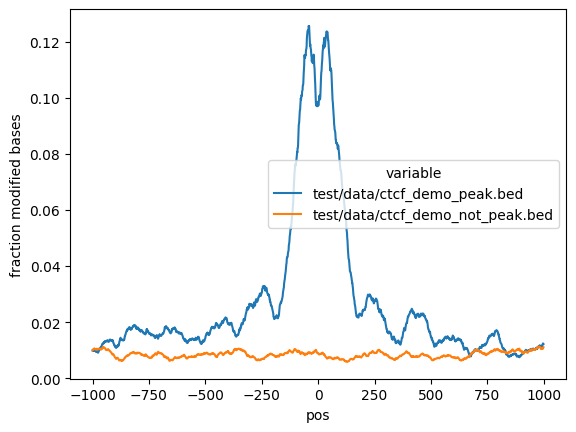

In [14]:
plot_enrichment_profile.by_regions(
    mod_file_name=pileup_file,
    bed_file_names=[ctcf_target_regions,ctcf_off_target_regions],
    window_size=1000,
    mod_name='A,0',
    smooth_window=50
)

## Plot Enrichment

In [15]:
from dimelo import plot_enrichment

<Axes: ylabel='fraction modified bases'>

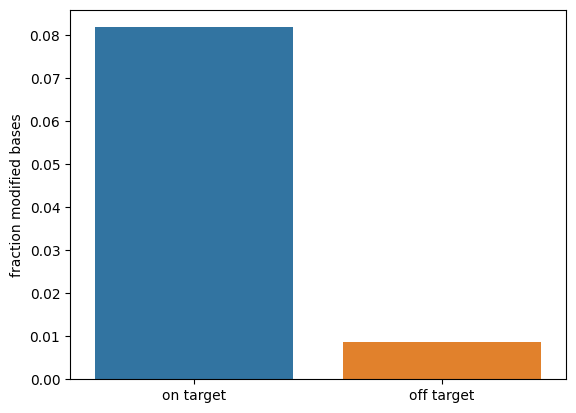

In [16]:
plot_enrichment.by_regions(mod_file_name=pileup_file,
                                bed_file_names=[ctcf_target_regions, ctcf_off_target_regions],
                                mod_name='A,0',
                                sample_names=['on target', 'off target'])

## Plot Reads

In [17]:
from dimelo import plot_reads

Loading regions from ctcf_demo_peak.bed using even 1000bp windows in either direction from bed region centers.
Writing new bed file ctcf_demo_peak.windowed1000-for-readout.bed


<Axes: xlabel='pos', ylabel='read_name'>

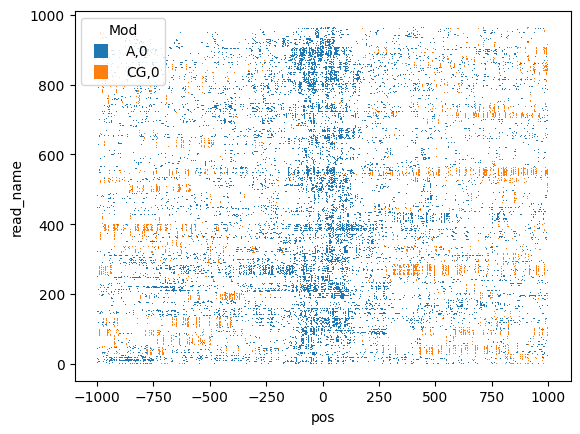

In [18]:
plot_reads.plot_reads(
    mod_file_name=extract_file,
    bed_file_name=ctcf_target_regions,
    mod_names=['A,0', 'CG,0'],
    window_size=1000
)